In [5]:
# Importing all the necessary dependencies
import sys
sys.path.append('..')
from searchutil import *
from judgements import *
import os
from IPython.display import display,HTML
from pyspark.sql import SparkSession
from solrclient import *
from solr import *
spark = SparkSession.builder.appName("search-project").getOrCreate()
client = SolrClient(solr_base=SOLR_URL)

In [6]:
# For reloading external files
%load_ext autoreload
%autoreload 2

# Searching the products collection with this boost values from User clicks data

###  Products Data

In [3]:

#Have downloaded the datasets of the products and signals and stored it in data folder.
! cd data/&& head products.csv

"upc","name","manufacturer","shortDescription","longDescription"
"096009010836","Fists of Bruce Lee - Dolby - DVD",\N,\N,\N
"043396061965","The Professional - Widescreen Uncut - DVD",\N,\N,\N
"085391862024","Pokemon the Movie: 2000 - DVD",\N,\N,\N
"067003016025","Summerbreeze - CD","Nettwerk",\N,\N
"731454813822","Back for the First Time [PA] - CD","Def Jam South",\N,\N
"024543008200","Big Momma's House - Widescreen - DVD",\N,\N,\N
"031398751823","Kids - DVD",\N,\N,\N
"037628413929","20 Grandes Exitos - CD","Sony Discos Inc.",\N,\N
"060768972223","Power Of Trinity (Box) - CD","Sanctuary Records",\N,\N


### Storing Products dataset to Apache Solr using Spark Read CSV

In [4]:
#Create Products Collection
products_collection="products"
create_collection(products_collection)

#Modify Schema to make some fields explicitly searchable by keyword
upsert_text_field(products_collection, "upc")
upsert_text_field(products_collection, "name")
upsert_text_field(products_collection, "longDescription")
upsert_text_field(products_collection, "manufacturer")

print("Loading Products...")
csvFile = "data/products.csv"
products_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csvFile)
print("Products Schema: ")
products_df.printSchema()

product_update_opts={"zkhost": "search-zk", "collection": products_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
products_df.write.format("solr").options(**product_update_opts).mode("overwrite").save()
print("Status: Success")

Wiping 'products' collection
[('action', 'CREATE'), ('name', 'products'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'products' collection
Status: Success
Adding 'upc' field to collection
Status: Success
Adding 'name' field to collection
Status: Success
Adding 'longDescription' field to collection
Status: Success
Adding 'manufacturer' field to collection
Status: Success
Loading Products...
Products Schema: 
root
 |-- upc: long (nullable = true)
 |-- name: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- shortDescription: string (nullable = true)
 |-- longDescription: string (nullable = true)

Status: Success


In [5]:
products_df.head(5)

[Row(upc=96009010836, name='Fists of Bruce Lee - Dolby - DVD', manufacturer='\\N', shortDescription='\\N', longDescription='\\N'),
 Row(upc=43396061965, name='The Professional - Widescreen Uncut - DVD', manufacturer='\\N', shortDescription='\\N', longDescription='\\N'),
 Row(upc=85391862024, name='Pokemon the Movie: 2000 - DVD', manufacturer='\\N', shortDescription='\\N', longDescription='\\N'),
 Row(upc=67003016025, name='Summerbreeze - CD', manufacturer='Nettwerk', shortDescription='\\N', longDescription='\\N'),
 Row(upc=731454813822, name='Back for the First Time [PA] - CD', manufacturer='Def Jam South', shortDescription='\\N', longDescription='\\N')]

### Searching in Apache Solr and checking if results are right

In [7]:
query = "ipod"

collection = "products"
request = {
    "query": query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "sort": "score desc, upc asc"
    }
}

search_results = requests.post(f"{SOLR_URL}/{collection}/select", json=request).json()["response"]["docs"]
display(HTML(render_search_results(query, search_results)))

### Signals Dataset

In [8]:
! cd data/ &&  tar -xzf signals.tgz signals.csv && head signals.csv

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


### Ingesting Signals Dataset to Solr Database

In [32]:
#Create Signals Collection
signals_collection="signals"
create_collection(signals_collection)

print("Loading Signals...")
csvFile = "data/signals.csv"
signals_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csvFile)
print("Signals Schema: ")
signals_df.printSchema()

signals_update_opts={"zkhost": "search-zk", "collection": signals_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
signals_df.write.format("solr").options(**signals_update_opts).mode("overwrite").save()
print("Status: Success")

Wiping 'signals' collection
[('action', 'CREATE'), ('name', 'signals'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'signals' collection
Status: Success
Loading Signals...
Signals Schema: 
root
 |-- query_id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- type: string (nullable = true)
 |-- target: string (nullable = true)
 |-- signal_time: timestamp (nullable = true)

Status: Success


In [10]:
signals_df.head(5)

[Row(query_id='u2_0_1', user='u2', type='query', target='nook', signal_time=datetime.datetime(2019, 7, 31, 8, 49, 7, 311600)),
 Row(query_id='u2_1_2', user='u2', type='query', target='rca', signal_time=datetime.datetime(2020, 5, 4, 8, 28, 21, 184800)),
 Row(query_id='u3_0_1', user='u3', type='query', target='macbook', signal_time=datetime.datetime(2019, 12, 22, 0, 7, 7, 15200)),
 Row(query_id='u4_0_1', user='u4', type='query', target='Tv antenna', signal_time=datetime.datetime(2019, 8, 22, 23, 45, 54, 103000)),
 Row(query_id='u5_0_1', user='u5', type='query', target='AC power cord', signal_time=datetime.datetime(2019, 10, 20, 8, 27, 0, 160000))]

### Boosting the signals

In [33]:
products_collection="products"
signals_collection="signals"
signals_boosting_collection="signals_boosting"

#We have the collection for products and signals. 
#Creating the collection for signals_boosting
create_collection(signals_boosting_collection)

print("Now we are aggregating to get signals boosts...")
signals_opts={"zkhost": "search-zk", "collection": signals_collection}
df = spark.read.format("solr").options(**signals_opts).load()
df.createOrReplaceTempView("signals")

# For each query we are storing how many times the document has been clicked.
signals_aggregation_query = """
select q.target as query, c.target as doc, count(c.target) as boost
  from signals c left join signals q on c.query_id = q.query_id
  where c.type = 'click' AND q.type = 'query'
  group by query, doc
  order by boost desc
"""

signals_boosting_opts={"zkhost": "search-zk", "collection": signals_boosting_collection, 
                       "gen_uniq_key": "true", "commit_within": "5000"}

#Writing the Boosted Signal Information to Apache Spark
spark.sql(signals_aggregation_query).write.format("solr").options(**signals_boosting_opts).mode("overwrite").save()
print("Signals Aggregation Completed!")

Wiping 'signals_boosting' collection
[('action', 'CREATE'), ('name', 'signals_boosting'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'signals_boosting' collection
Status: Success
Now we are aggregating to get signals boosts...
Signals Aggregation Completed!


### For the query ipad, collecting the documents and their boosts

In [12]:
query = "ipad"

signals_boosts_query = {
    "query": query,
    "fields": ["doc", "boost"],
    "limit": 10,
    "params": {
      "defType": "edismax",
      "qf": "query",
      "sort": "boost desc"
    }
}

signals_boosts = requests.post(f"{SOLR_URL}/{signals_boosting_collection}/select", 
                               json=signals_boosts_query).json()["response"]["docs"]
print(f"Boost Documents for the query ipad: \n{signals_boosts}")

Boost Documents for the query ipad: 
[{'doc': '885909457588', 'boost': 966}, {'doc': '885909457595', 'boost': 205}, {'doc': '885909471812', 'boost': 202}, {'doc': '886111287055', 'boost': 109}, {'doc': '843404073153', 'boost': 73}, {'doc': '635753493559', 'boost': 62}, {'doc': '885909457601', 'boost': 62}, {'doc': '885909472376', 'boost': 61}, {'doc': '610839379408', 'boost': 29}, {'doc': '884962753071', 'boost': 28}]


In [13]:
# Here we are generating the list of signal boosts to query on the final parameter called "signals_boosting" for products collection
product_boosts = " ".join(
    [f'"{entry["doc"]}"^{str(entry["boost"])}' 
     for entry in signals_boosts])
print(f"\nBoost Query: \n{product_boosts}")

collection = "products"
request = {
    "query": query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "indent": "true",
      "sort": "score desc, upc asc",
      "qf": "name manufacturer longDescription",
      "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
      "signals_boosting": product_boosts
    }
}

search_results = requests.post(f"{SOLR_URL}/{collection}/select", json=request).json()["response"]["docs"]
display(HTML(render_search_results(query, search_results)))


Boost Query: 
"885909457588"^966 "885909457595"^205 "885909471812"^202 "886111287055"^109 "843404073153"^73 "635753493559"^62 "885909457601"^62 "885909472376"^61 "610839379408"^29 "884962753071"^28


# Searching with the related keywords

We find the queries that are similar in fashion. The basic intuition is if user 1 types a query q1 and clicks product p and if user 2 types a query q2 and clicks on same product, we can assume that both queries q1 and q2 are related.

In [13]:
# We are doing join on searches.query_id and clicks.query_id to find the query that user has entered and the product that he has clicked on
spark.sql(
  """
    select lower(searches.target) as keyword, searches.user as user, clicks.target as product 
    from signals as searches
    right join signals as clicks on searches.query_id = clicks.query_id 
    where searches.type='query' and clicks.type = 'click'
  """
).createOrReplaceTempView('keyword_click_product')


In [14]:

print("Signals Dataset format: ")
spark.sql(
    '''
      select * from signals where type='query' 
    '''
).show(5, truncate=False)

print("Extracted Signals format: ")
spark.sql(
    '''
      select * from keyword_click_product
    '''
).show(5)

Signals Dataset format: 
+------------------------------------+-----------+-----------------------+-------------------+-----+-------+
|id                                  |query_id   |signal_time            |target             |type |user   |
+------------------------------------+-----------+-----------------------+-------------------+-----+-------+
|00000b9d-d8d4-4fae-94a8-3e8f136bd831|u257554_0_1|2019-07-21 16:30:37.185|HP touchpad        |query|u257554|
|000057be-bb5f-4989-90ca-2866e5c7e837|u25470_0_1 |2020-01-22 00:11:36.601|Samsung galaxy s2  |query|u25470 |
|000161ee-5266-46fb-b79a-c7755f525f84|u48995_2_3 |2020-04-09 23:32:41.058|Pirates 3d         |query|u48995 |
|000238f3-c630-4b3c-8113-8bbaeb85e24c|u612748_2_4|2020-04-10 06:25:46.385|external dvd burner|query|u612748|
|00027ab3-dc8a-4a6b-aa21-f9bda95e5294|u80429_0_1 |2019-07-14 09:59:13.678|wireless headset   |query|u80429 |
+------------------------------------+-----------+-----------------------+-------------------+-----+---

In [15]:
# Now we try to find number of users who have clicked on the product with query q1 and another query q2
spark.sql("""
select q1.keyword as q1, q2.keyword as q2, sum(p1) n_users1,sum(p2) n_users2, 
sum(p1+p2) as users_cooc, count(1) n_products
from
(select keyword, product, count(1) as p1 from keyword_click_product group by keyword, product) as q1 
join
(select keyword, product, count(1) as p2 from keyword_click_product group by keyword, product) as q2
on q1.product = q2.product
where q1.keyword > q2.keyword 
group by q1.keyword, q2.keyword
""").createOrReplaceTempView('query_click_product')

In [16]:
#Show Results:
spark.sql('''select count(1) as query_click_product_count from query_click_product''').show()
spark.sql('''select * from query_click_product order by n_products desc''').show(20)

+-------------------------+
|query_click_product_count|
+-------------------------+
|                  1579710|
+-------------------------+

+--------------+-------------+--------+--------+----------+----------+
|            q1|           q2|n_users1|n_users2|users_cooc|n_products|
+--------------+-------------+--------+--------+----------+----------+
|       laptops|       laptop|    3251|    3345|      6596|       187|
|       tablets|       tablet|    1510|    1629|      3139|       155|
|        tablet|         ipad|    1468|    7067|      8535|       146|
|       tablets|         ipad|    1359|    7048|      8407|       132|
|       cameras|       camera|     637|     688|      1325|       116|
|          ipad|        apple|    6706|    1129|      7835|       111|
|      iphone 4|       iphone|    1313|    1754|      3067|       108|
|    headphones|  head phones|    1829|     492|      2321|       106|
|        ipad 2|         ipad|    2736|    6738|      9474|        98|
|     c

In [17]:
#Calculation:
spark.sql("""
select keyword, count(1) as n_users from keyword_click_product group by keyword 
""").createOrReplaceTempView('keyword_click_product_oc')

In [18]:
#Show Results:
spark.sql('''select count(1) as keyword_click_product_count from keyword_click_product_oc''').show()
spark.sql('''select * from keyword_click_product_oc order by n_users desc''').show(20)

+---------------------------+
|keyword_click_product_count|
+---------------------------+
|                      13744|
+---------------------------+

+------------+-------+
|     keyword|n_users|
+------------+-------+
|        ipad|   7554|
| hp touchpad|   4829|
|      lcd tv|   4606|
|   iphone 4s|   4585|
|      laptop|   3554|
|       beats|   3498|
|     laptops|   3369|
|        ipod|   2949|
|  ipod touch|   2931|
|      ipad 2|   2842|
|      kindle|   2833|
|    touchpad|   2785|
|   star wars|   2564|
|      iphone|   2430|
|beats by dre|   2328|
|     macbook|   2313|
|  headphones|   2270|
|        bose|   2071|
|         ps3|   2041|
|         mac|   1851|
+------------+-------+
only showing top 20 rows



In [19]:
spark.sql(
    '''
        select q1.keyword as q1, q2.keyword as q2, q1_q2.users_cooc, q1.n_users as n_users1,q2.n_users as n_users2,
        log(pow(q1_q2.users_cooc,2)/(q1.n_users*q2.n_users)) as pmi2
        from
        query_click_product as q1_q2 
        join
        keyword_click_product_oc as q1 on q1_q2.q1 = q1.keyword
        join
        keyword_click_product_oc as q2 on q1_q2.q2 = q2.keyword
    '''
).createOrReplaceTempView('product_related_keywords_pmi')

We are calculating Pointwise Mutual Information scores to find the suitable confidence of number of times the user has entered query q1 and q2 respectively

In [20]:
#Show Results:
spark.sql('''select count(1) as related_keywords_pmi from product_related_keywords_pmi''').show()
spark.sql('''select * from product_related_keywords_pmi order by pmi2 desc''').show(20)

+--------------------+
|related_keywords_pmi|
+--------------------+
|             1579710|
+--------------------+

+-------------------+-------------------+----------+--------+--------+------------------+
|                 q1|                 q2|users_cooc|n_users1|n_users2|              pmi2|
+-------------------+-------------------+----------+--------+--------+------------------+
|        hp touchpad|    hp tablet 32 gb|      4022|    4829|       1| 8.116674454791653|
|          pad pivot|        hp touchpad|      4022|       1|    4829| 8.116674454791653|
|        hp touchpad|     hp tablet 32gb|      4022|    4829|       1| 8.116674454791653|
|     hp touchpad 32|        hp touchpad|      4022|       1|    4829| 8.116674454791653|
|           touchpad|          pad pivot|      2350|    2785|       1| 7.592338061915025|
|           touchpad|     hp touchpad 32|      2350|    2785|       1| 7.592338061915025|
|           touchpad|     hp tablet 32gb|      2350|    2785|       1| 7.5

As we can see, we though the records are sorted by PMI, the one with less clicks is getting more weight for the pmi. We need to balance with by using composite score so that we can get the even distribution for both queries q1 and q2.

In [21]:
# calculate comp_score

#Calculation:
spark.sql(
  '''
  select  *, (r1 + r2 /( r1 * r2))/2 as comp_score from (
  select *, 
    rank() over (partition by 1 order by users_cooc desc )  r1 , 
    rank() over (partition by 1 order by pmi2 desc )  r2  
    from product_related_keywords_pmi ) a  
  '''
).createOrReplaceTempView('related_keywords_comp_score')

In [22]:
#Show Results:
spark.sql( '''
  select count(1) related_keywords_comp_scores_count from related_keywords_comp_score
''').show()

spark.sql( '''
  select q1, q2, n_users1, n_users2, pmi2 as pmi2_score, comp_score as composite_score 
  from related_keywords_comp_score
  order by comp_score asc
''').show(20)

+----------------------------------+
|related_keywords_comp_scores_count|
+----------------------------------+
|                           1579710|
+----------------------------------+

+----------+-----------+--------+--------+------------------+------------------+
|        q1|         q2|n_users1|n_users2|        pmi2_score|   composite_score|
+----------+-----------+--------+--------+------------------+------------------+
|      ipad|hp touchpad|    7554|    4829|1.2318940540272372|               1.0|
|    ipad 2|       ipad|    2842|    7554| 1.430517155037946|              1.25|
|    tablet|       ipad|    1818|    7554|1.6685364924472557|1.6666666666666667|
|  touchpad|       ipad|    2785|    7554|1.2231908670315748|             2.125|
|   tablets|       ipad|    1627|    7554|1.7493143317791537|               2.6|
|     ipad2|       ipad|    1254|    7554|1.9027023623302282|3.0833333333333335|
|      ipad|      apple|    7554|    1814|1.4995901756327583|3.5714285714285716|
|  t

We can see above that the related keywords are q1 and q2. The low comp_score indicates that they are closely related keywords. We can see that our results are giving somewhat semantically related keywords.

# Finding wrongly spelled words and mapping it with correct one

In [23]:
#Importing all the relevant nltk libraries
import nltk
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
nltk.download('stopwords')
import json

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here we are querying the products collection with the query "moden" which is not present in the database and we query with the similar document with the edit distance of 1 "modern".

We can observe that there are search results for correct query and for the wrong query it gives 0 records.

In [24]:
collection="products"
wrong_query = "moden"
correct_query="modern"

correct_request = {
    "query": correct_query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "sort": "score desc, upc asc"
    }
}
wrong_request = {
    "query": wrong_query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "sort": "score desc, upc asc"
    }
}


#search_results = requests.post(f"{SOLR_URL}/{collection}/spell", json=request).json()
search_results_for_wrong_query = requests.post(f"{SOLR_URL}/{collection}/select", json=wrong_request).json()["response"]["docs"]
print(f"Documents present in products collection for the query {wrong_query}: \n{search_results_for_wrong_query}")

search_results_for_correct_query = requests.post(f"{SOLR_URL}/{collection}/select", json=correct_request).json()["response"]["docs"]
print(f"Documents present in products collection for the query {correct_query}: \n{search_results_for_correct_query}")

#print(json.dumps(search_results["spellcheck"]["collations"], indent=4))

Documents present in products collection for the query moden: 
[]
Documents present in products collection for the query modern: 
[{'upc': '75597997705', 'name': 'Young Modern - CD', 'manufacturer': 'Eleven', 'score': 4.2432804}, {'upc': '15707990516', 'name': 'Modern Love [LP] - VINYL', 'manufacturer': 'Vanguard', 'score': 3.9586327}, {'upc': '15707990523', 'name': 'Modern Love [Digipak] - CD', 'manufacturer': 'Vanguard', 'score': 3.9586327}, {'upc': '29986919519', 'name': 'Altra - Modern Mission Desk', 'manufacturer': 'Altra', 'score': 3.9586327}, {'upc': '715515064811', 'name': 'Modern Times - Fullscreen - DVD', 'manufacturer': '\\N', 'score': 3.9586327}]


In [25]:
#Now we will use the signals dataset to get the matched queries
signals_collection="signals"
signals_opts={"zkhost": "search-zk", "collection": signals_collection}
df = spark.read.format("solr").options(**signals_opts).load()
df.createOrReplaceTempView("signals")

In [26]:
### Create user-searchs table each raw represent one search query.
query_signals = spark.sql(
    """
    select lower(trim(searches.target)) as keyword, searches.user as user 
    from signals as searches where searches.type='query'
    group by keyword, user
  """
).collect()

### Now we tokenise the queries and find word frequencies. For the frequency distribution quantiles, we can choose the cutoff point to get only useful misspellings

In [27]:
stop_words = set(stopwords.words('english'))
word_list = defaultdict(int)

for row in query_signals:
    query = row["keyword"]
    tokenizer = RegexpTokenizer(r'\w+') 
    tokens   = tokenizer.tokenize(query)
    
    for token in tokens:
        if token not in stop_words and len(token) > 3 and not token.isdigit():  #drop stopwords and digit only tokens
            # and only consider token length > 3, since hard to judge whether a very short token is misspelled or not
            word_list[token] += 1

In [28]:
print(sorted(word_list.items(), key=lambda x: x[1]))

[('sevendust', 4), ('idol', 4), ('viva', 4), ('stanley', 4), ('kubrick', 4), ('acessories', 4), ('w530', 4), ('raging', 4), ('enchanted', 4), ('carolina', 5), ('gangs', 5), ('york', 5), ('valet', 5), ('ride', 5), ('bicycles', 5), ('500d', 5), ('bridesmades', 5), ('carrabean', 5), ('lilwayne', 5), ('ninjas', 5), ('celulares', 5), ('rsg257aars', 5), ('l655', 5), ('3790lmt', 5), ('retractable', 5), ('s3000', 5), ('360s', 5), ('snowball', 5), ('igroove', 5), ('tropic', 5), ('bbr6', 5), ('motorstorm', 5), ('motorla', 5), ('wx10', 5), ('pioner', 5), ('diner', 5), ('picks', 5), ('lamb', 5), ('inna', 5), ('isolating', 5), ('cookers', 5), ('un60d6400', 5), ('native', 5), ('covenant', 5), ('tesla', 5), ('inspiring', 5), ('locations', 5), ('matthew', 5), ('relapse', 5), ('wf330anw', 5), ('ln40d550', 5), ('reason', 5), ('microvision', 5), ('chimaera', 5), ('nofx', 5), ('cadillac', 5), ('records', 5), ('alianware', 5), ('morning', 5), ('multimedia', 5), ('1000w', 5), ('catch', 5), ('32in', 5), ('te

As we tokenise and find the dictionary count, we can observe that there are some records with less dict values which are correct and rare. Then there are other records which are incorrect. We will extract the words that are incorrect using edit distance. Before that we will find all these types of queries using the quartile ranges.

In [29]:
quantiles_to_check = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
quantile_values = np.quantile(np.array(list(word_list.values())), quantiles_to_check)
quantiles = dict(zip(quantiles_to_check, quantile_values))
quantiles

{0.1: 5.0,
 0.2: 6.0,
 0.3: 8.0,
 0.4: 12.0,
 0.5: 16.0,
 0.6: 25.0,
 0.7: 47.0,
 0.8: 142.20000000000027,
 0.9: 333.2000000000007}

Here we can see the dict values corresponding to respective quartiles.

In [30]:
misspell_candidates = []
correction_candidates = []

misspell_counts = []
correction_counts = []

misspell_length = []
correction_length = []

misspell_initial = []
correction_initial = []


#consider word with low count as misspelling condidates, with high count as correctly spelled candidates. 
for k, v in word_list.items():
    if v <= quantiles[0.2] : #if v == 1:  # this number based on quantile analysis and the data set, more-likely with user-behvaiour data set to be 1
        misspell_candidates.append(k)
        misspell_counts.append(v)
        misspell_length.append(len(k))
        misspell_initial.append(k[0])
    if v >= quantiles[0.8]:
        correction_candidates.append(k)
        correction_counts.append(v)
        correction_length.append(len(k))
        correction_initial.append(k[0])

In [31]:
print(misspell_candidates)

['sevendust', 'mute', 'math', 'luther', 'vandross', 'nintendogs', 'tosheba', 'singin', 'carolina', 'gangs', 'york', 'valet', 'ride', 'bicycles', 'jerry', '500d', 'bridesmades', 'carrabean', 'lilwayne', 'dinosaur', 'born', 'ninjas', 'celulares', 'kompressor', 'hurt', 'rsg257aars', 'ferrari', 'l655', '3790lmt', 'plane', 'retractable', 'thermometer', 'ricky', 'hawking', 's3000', '360s', 'crockpot', 'snowball', 'droidx', 'igroove', 'atlantic', 'encounter', 'tropic', 'currington', 'bbr6', 'caption', 'hughes', 'motorstorm', 'motorla', 'assassination', 'catz', 'wx10', 'rebelution', 'conchords', 'hour', 'anything', 'pioner', 'diner', 'picks', 'lamb', 'xmp3i', 'wfw9150ww', 'inna', 'isolating', 'cookers', 'aventura', 'un60d6400', 'native', 'covenant', 'tesla', 'inspiring', 'orchestra', 'jacka', 'locations', 'monkeys', 'matthew', 'relapse', 'wf330anw', 'p104', 'ln40d550', 'reason', 'running', 'microvision', 'haupauge', 'exercise', 'chimaera', 'nofx', 'cadillac', 'records', 'streamer', 'alianware'

In [32]:
print(correction_candidates)

['playstation', 'move', 'nikon', 'touchpad', 'ipad', 'universal', 'laptop', 'charger', 'sony', 'ipad2', 'thor', 'droid', 'incredible', 'computer', 'memory', 'grand', 'rocketfish', 'card', 'reader', 'roku', 'iphone', 'subwoofer', 'camera', 'macbook', 'anti', 'virus', 'transformers', 'eureka', 'd7000', 'flat', 'screen', 'xbox', 'live', 'tablet', 'flyer', 'king', 'queens', 'laptops', 'android', 'gateway', 'ipod', 'shuffle', 'cameras', 'phillips', 'antenna', 'cable', 'five', 'finger', 'death', 'punch', 'portable', 'player', 'canon', 'speaker', 'tower', 'phone', 'classic', 'magellan', 'touch', 'screens', 'rebel', 'apple', 'boost', 'mobile', 'radio', 'sims', 'pets', 'otterbox', 'cell', 'phones', 'smart', 'power', 'inverter', 'asus', 'beats', 'washer', 'galaxy', 'slingbox', 'panasonic', 'soundbar', 'modems', 'sharp', 'wall', 'mount', 'cases', 'flatout', 'dell', 'transformer', 'samsung', 'monitor', 'video', 'capture', 'netbook', 'mortal', 'nintendo', 'system', 'rechargeable', 'batteries', 'god

In [33]:
# We maintain in the dataframe format so that it is used further for preprocessing
misspell_candidates_df = pd.DataFrame({
    "misspell":misspell_candidates, 
    "misspell_counts":misspell_counts, 
    "misspell_length":misspell_length,
    "initial":misspell_initial})

correction_candidates_df = pd.DataFrame({
    "correction":correction_candidates, 
    "correction_counts":correction_counts, 
    "correction_length":correction_length,
    "initial":correction_initial})

In [34]:
misspell_candidates_df.head(10)

,misspell,misspell_counts,misspell_length,initial
0,sevendust,4,9,s
1,mute,6,4,m
2,math,6,4,m
3,luther,6,6,l
4,vandross,6,8,v
5,nintendogs,6,10,n
6,tosheba,6,7,t
7,singin,6,6,s
8,carolina,5,8,c
9,gangs,5,5,g


We calculate the edit distance for the misspelled word and the correct word

In [35]:
def good_match(len1, len2, edit_dist): #allow longer words have more edit distance
    match = 0
    min_length = min(len1, len2)
    if min_length < 8:
        if edit_dist == 1: match = 1
    elif min_length < 11:
        if edit_dist <= 2: match = 1
    else:
        if edit_dist == 3: match = 1
    return match

In [36]:
matches_candidates = pd.merge(misspell_candidates_df, correction_candidates_df, on="initial")
#join missepll list with correction list based on whether they share the same initials to reduce matching time. 


matches_candidates["edit_dist"] = matches_candidates.apply(
    lambda row: nltk.edit_distance(row.misspell,row.correction), axis=1)


matches_candidates["good_match"] = matches_candidates.apply(
    lambda row: good_match(row.misspell_length, row.correction_length, row.edit_dist),axis=1)

In [37]:
matches = matches_candidates[matches_candidates["good_match"] == 1].drop(["initial","good_match"],axis=1)

### We prefer shorter edit distance and having higher frequency counts.

In [38]:
matches_final = matches.groupby('misspell').first().reset_index()

In [39]:
matches_final.sort_values(by=['correction_counts'], ascending=[False])[["misspell", "correction", "misspell_counts", "correction_counts", "edit_dist"]].head(20)

,misspell,correction,misspell_counts,correction_counts,edit_dist
50,iphone3,iphone,6,16854,1
61,laptopa,laptop,6,14119,1
62,latop,laptop,5,14119,1
137,touxhpad,touchpad,5,11550,1
136,toucpad,touchpad,6,11550,1
148,wirless,wireless,6,10060,1
127,tableta,tablet,6,8260,1
8,cage,case,6,7541,1
10,cape,case,5,7541,1
30,gallaxy,galaxy,6,5839,1


# Finding the weightage values to be sent in a query for two attributes

In [11]:
#Now we will use the signals dataset to get the matched queries
signals_collection="signals"
signals_opts={"zkhost": "search-zk", "collection": signals_collection}
signals_df = spark.read.format("solr").options(**signals_opts).load()
signals_df.createOrReplaceTempView("signals")

In [12]:
query_clicks = spark.sql(
"""
select distinct(lower(q.target)) as query, c.target as doc, count(c.target) as boost
  from signals c left join signals q on c.query_id = q.query_id
  where c.type = 'click' AND q.type = 'query'
  group by query, doc
  order by boost desc
"""
).collect()

In [13]:
distinct_queries=[]
query_counts = []
for row in query_clicks:
    query = row["query"]
    distinct_queries.append(query)
    query_counts.append(float(row["boost"]))
print(len(distinct_queries))

152251


So we have 152251 records in the signals dataset where the user has entered the query and clicked on the document. We need to extract only few queries to create the judgement list

In [14]:
query_clicks_few = spark.sql(
"""
select distinct(lower(q.target)) as query, c.target as doc, count(c.target) as boost
  from signals c left join signals q on c.query_id = q.query_id
  where c.type = 'click' AND q.type = 'query'
  group by query, doc
  order by boost desc
  limit 100
"""
).collect()

I am taking only top 100 queries as to collect juddgements for each query it is taking 5 sec and I want to run the cell upto 10 min and collect as many judgements list as possible.

As we are referencing from the book, the authors used only 12 queries to create judgement lists. The more number of judgement lists the better the search behaves. So, I am taking upto for 500 queries and store it in the glob file, so that we can import it next time

In [15]:
top_100_queries=[]
for row in query_clicks_few:
    query = row["query"]
    top_100_queries.append(query)
print(top_100_queries)

['hp touchpad', 'ipad', 'touchpad', 'lcd tv', 'ipod touch', 'star wars', 'htc flyer', 'lcd tv', 'ipod', 'ipad 2', 'apple tv', 'hp tablet', 'macbook', 'ps3', 'iphone 4s', 'transformers', 'thor', 'iphone 4s', 'kindle fire', 'mac', 'ipad', 'macbook pro', 'ipad', 'kindle', 'beats', 'lcd tv', 'imac', 'hp touch pad', 'ipad2', 'ipod touch', 'kindle', 'roku', 'captain america', 'beats', 'google tv', 'playstation 3', 'bridesmaids', 'tivo', 'lil wayne', 'watch the throne', 'kindle', 'thor', 'captain america', 'ipod', 'dead island', 'ipod nano', 'roku', 'lil wayne', 'beats by dre', 'nook', 'just dance 3', 'slingbox', 'ipad', 'battlefield 3', 'apple', 'xoom', 'nook', 'ico', 'green lantern', 'iphone 4', 'lcd tv', 'i pad', 'madden 12', 'iphone 4s', 'star wars blu ray', 'fast five', 'cable modem', 'ps3 console', 'galaxy tab', 'lion king', 'mac mini', 'playbook', 'lion king', 'xmen first class', 'beats by dre', 'tablet', 'cable modem', 'slingbox', 'batman', 'beats', 'projector', 'dvr', 'wii', 'ipad 2'

## Running simulations to get the rank of the product

We can observe that the signals dataset doesn't have the rank of the product clicked. We dont know if the user clicked on the second document or the 3rd document. We'll generate the rank based on simulating some of the search results and mapping it to the signals datset to find the rank of the product.

In [10]:
MIN_QUERY_EVENTS=100
signals = pd.read_csv('data/signals.csv')
queries = signals[signals['type'] == 'query']
popular_queries = queries.groupby('target').count() \
                         .rename(columns={'query_id': 'query_count'}) \
                         .sort_values('query_count', ascending=False)
popular_queries = popular_queries[popular_queries['query_count'] > MIN_QUERY_EVENTS].index.to_list()
pop_query_events = signals[signals['type'] == 'query'][signals['target'].isin(popular_queries)]
query_events = pop_query_events[['query_id', 'target']].rename(columns={'target': 'query'})
query_events['query'] = query_events['query'].apply(lambda q: q.lower())
query_event_counts = query_events.groupby('query')['query_id'].count().reset_index().sort_values('query_id', ascending=False)


/tmp/ipykernel_1440/1549935477.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  signals = pd.read_csv('data/signals.csv')
/tmp/ipykernel_1440/1549935477.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pop_query_events = signals[signals['type'] == 'query'][signals['target'].isin(popular_queries)]


In [46]:
query_event_counts

,query,query_id
613,lcd tv,8254
512,ipad,7754
482,hp touchpad,7019
523,iphone 4s,4606
1114,touchpad,3990
...,...,...
563,juicer,101
1000,smart tv,101
1031,speck,101
1036,sprint,101


In [47]:
clicks = signals[signals['type'] == 'click']
click_events = clicks[['query_id', 'target']].rename(columns={'target': 'clicked_doc_id'})
clicks_per_query = query_events.merge(click_events, 
                                      on='query_id', 
                                      how='left')
clicks_per_query['clicked_doc_id'] = clicks_per_query['clicked_doc_id'].fillna(0)
clicks_per_query

,query_id,query,clicked_doc_id
0,u2_0_1,nook,9781400532650
1,u2_1_2,rca,883393001119
2,u3_0_1,macbook,885909464036
3,u4_0_1,tv antenna,079000334835
4,u7_0_1,camcorder,027242821866
...,...,...,...
488077,u744327_0_1,dre beats,848447000135
488078,u744328_0_1,sirius radio,884720004032
488079,u744330_0_1,usb drive,718037770604
488080,u744331_0_1,iphone 4s,885909538027


The below three cells are for calculating the click through rate by simulating the search sessions. 

In [48]:
# total number of queries (denom if CTR)
denominator = query_events.groupby('query').count().rename(columns={'query_id': 'tot_query_count'})

# click counts per doc in query
click_thru_rate = clicks_per_query.groupby(['query', 'clicked_doc_id']).count().rename(columns={'query_id':'click_count'}).reset_index()
click_thru_rate = click_thru_rate.merge(denominator, on='query', how='left')

click_thru_rate['ctr'] = click_thru_rate['click_count'] / click_thru_rate['tot_query_count']
click_thru_rate = click_thru_rate.sort_values(['query', 'ctr'], ascending=[True, False])

# Get rid of doc_id 0, which is all the queries with no clicks
# We treat these as a canonical ranking from the source system, assume it's relatively
# highly tuned and the source CTRs are pretty reasonably close to actual relevance ranking
# in the source system. Of course this is a dubious assumption in a real search system, 
# but for our purposes - to synthesize reasonable looking search sessions - it will serve
canonical_rankings = click_thru_rate[click_thru_rate['clicked_doc_id'] != 0].reset_index()


In [49]:
canonical_rankings['rank'] = canonical_rankings.groupby('query').cumcount()

# Idea
# Compute neg z scores for items below mean and positive z scores for items above mean
# but negative z scores are fit to a distribution of only the negative values and the negative values + mean
# similarly for positive values

max_depth = canonical_rankings['rank'].max()
for i in range(0, max_depth):
    idxs = canonical_rankings[canonical_rankings['rank'] == i].index
   
    # Mean based statistics
    canonical_rankings.loc[idxs, 'posn_ctr_mean'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mean()
    canonical_rankings.loc[idxs, 'posn_ctr_std'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].std()
 
    # Median based statistics (less outlier prone)
    canonical_rankings.loc[idxs, 'posn_ctr_median'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].median()
    canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()

canonical_rankings['ctr_std_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_mean']) / canonical_rankings['posn_ctr_std']
canonical_rankings['ctr_mod_z_score'] = (canonical_rankings['ctr'] - canonical_rankings['posn_ctr_median']) / canonical_rankings['posn_ctr_mad']

orig_dryer = canonical_rankings[canonical_rankings['query'] == 'dryer'].head(20)
orig_dryer

/tmp/ipykernel_65/841443872.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()
/tmp/ipykernel_65/841443872.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  canonical_rankings.loc[idxs, 'posn_ctr_mad'] = canonical_rankings[canonical_rankings['rank'] == i]['ctr'].mad()


,index,query,clicked_doc_id,click_count,tot_query_count,ctr,rank,posn_ctr_mean,posn_ctr_std,posn_ctr_median,posn_ctr_mad,ctr_std_z_score,ctr_mod_z_score
14938,15202,dryer,12505451713,20,246,0.081301,0,0.211304,0.172619,0.155033,0.124698,-0.753122,-0.591287
14939,15251,dryer,883929085118,18,246,0.073171,1,0.117482,0.070920,0.105263,0.054663,-0.624809,-0.587101
14940,15245,dryer,883049066905,16,246,0.065041,2,0.083791,0.049181,0.075949,0.039165,-0.381257,-0.278534
14941,15212,dryer,36172950027,13,246,0.052846,3,0.062890,0.036442,0.058036,0.029238,-0.275618,-0.177514
14942,15228,dryer,74108056764,13,246,0.052846,4,0.049413,0.030312,0.045579,0.024283,0.113256,0.299232
14943,15230,dryer,77283045400,13,246,0.052846,5,0.039093,0.024632,0.037329,0.019862,0.558328,0.781220
14944,15241,dryer,783722274422,13,246,0.052846,6,0.029845,0.019055,0.029049,0.015626,1.207082,1.522870
14945,15238,dryer,665331101927,11,246,0.044715,7,0.024240,0.016162,0.023392,0.013554,1.266870,1.573186
14946,15206,dryer,14381196320,9,246,0.036585,8,0.020382,0.014220,0.018692,0.011989,1.139502,1.492543
14947,15229,dryer,74108096487,9,246,0.036585,9,0.017318,0.012207,0.015152,0.010458,1.578385,2.049542


In [50]:
import random
DOCS_PER_SESSION=30 # how many docs in one search page view?
NUM_SESSIONS=5000 # how many sessions to generate for each query?
def dest_rankings(n, query, baselines):
    if query not in baselines:
        shuffled = canonical_rankings[canonical_rankings['query'] == query]
        shuffled = shuffled[['posn_ctr_mean', 'posn_ctr_std', 'rank', 'posn_ctr_mad', 'posn_ctr_median']]\
                    .rename(columns={'rank': 'dest_rank'})
        shuffled = shuffled[shuffled['dest_rank'] < n].sample(frac=1)
        baselines[query] = shuffled    
    return baselines[query]

def slightly_random_ranking(n, query, baselines):
    top_n = dest_rankings(n, query, baselines).copy()
    to_swap = list(range(0,20))
    random.shuffle(to_swap)
    to_swap = to_swap[:8]
    
    for a, b in zip(to_swap, to_swap[1:]):
        if a in top_n and b in top_n:
            b_val = top_n.iloc[b]
            a_val = top_n.iloc[a].copy()
            top_n.iloc[a] = b_val
            top_n.iloc[b] = a_val
    
    # Swap a few posns
    return top_n

def synthesize_session(query, sess_id, baselines):
    posn_weights=[]
    m1 = canonical_rankings['query'] == query
    m2 = canonical_rankings['rank'] < DOCS_PER_SESSION
    canonical = canonical_rankings[m1 & m2]
    
    top_n = slightly_random_ranking(DOCS_PER_SESSION, query, baselines)
    
    
    
    shuffled = top_n.rename(columns={'posn_ctr_std': 'dest_ctr_std',
                         'posn_ctr_mean': 'dest_ctr_mean',
                         'posn_ctr_mad': 'dest_ctr_mad',
                         'posn_ctr_median': 'dest_ctr_median'})
    shuffled = shuffled.reset_index(drop=True).reset_index().rename(columns={'index': 'rank'})
    shuffled = shuffled.merge(canonical, on='rank', how='left')
    shuffled['dest_ctr_median_based'] = (shuffled['ctr_mod_z_score'] * shuffled['dest_ctr_mad']) + (shuffled['dest_ctr_median'])
    shuffled['dest_ctr_mean_based'] = (shuffled['ctr_std_z_score'] * shuffled['dest_ctr_std']) + (shuffled['dest_ctr_mean'])
    shuffled['draw'] = np.random.rand(len(shuffled))
    shuffled['clicked'] = shuffled['draw'] < shuffled['dest_ctr_mean_based']
    shuffled['sess_id'] = sess_id

    return shuffled

baselines={}

I have ran the session simulation code for the below and stored it at "data/sessions/sessions_data.gz".  You can load the file directly for evaluation. 

If you want to simulate the sessions uncomment below 2 cells and run it for 10-15 minutes. I am only collecting 2000 sessions for each query and it is taking me 20 seconds for each query.

The more the number the sessions, the large data you would get and it will result in better accuracy of the model.

In [54]:
# from time import perf_counter 
# session_list =[]
# for query in top_100_queries:
#     try:
#         sess_id = 0
#         session_dfs=[]
#         t1_start = perf_counter()  
#         if len(canonical_rankings[canonical_rankings['query'] == query]) > 0:
#             for i in range(0, NUM_SESSIONS):
#                 session_dfs.append(synthesize_session(query, sess_id, baselines))
#                 sess_id+=1
#                 if (sess_id >=2000):
#                     print("Created Sessions %s Last Query %s Elapsed %s" % (sess_id, query, perf_counter()-t1_start))
#                     break # For each search query I am taking only upto 500 values
#         else:
#             print("Query %s not available" % query)

#         sessions_for_query = pd.concat(session_dfs)
#         sessions_for_query = sessions_for_query.sort_values(['sess_id', 'dest_rank'])
#         sessions_for_query = sessions_for_query[['sess_id', 'query', 'dest_rank', 'clicked_doc_id', 'clicked']] \
#             .rename(columns={'dest_rank': 'rank'})
#         session_list.append(sessions_for_query)
#     except KeyboardInterrupt:
#         break
#     except:
#         continue
# sessions = pd.concat(session_list)

Created Sessions 500 Last Query hp touchpad Elapsed 3.8690093770019303
Created Sessions 500 Last Query ipad Elapsed 4.529742834998615
Created Sessions 500 Last Query touchpad Elapsed 4.630903084998863
Created Sessions 500 Last Query lcd tv Elapsed 4.221982376999222
Created Sessions 500 Last Query ipod touch Elapsed 4.064101084997674
Created Sessions 500 Last Query star wars Elapsed 3.9091457100003026
Created Sessions 500 Last Query htc flyer Elapsed 4.237555209998391
Created Sessions 500 Last Query lcd tv Elapsed 3.8509002099999634
Created Sessions 500 Last Query ipod Elapsed 3.8279784599981213
Created Sessions 500 Last Query ipad 2 Elapsed 3.866629001997353
Created Sessions 500 Last Query apple tv Elapsed 4.449091293998208
Created Sessions 500 Last Query hp tablet Elapsed 4.0560232940006244
Created Sessions 500 Last Query macbook Elapsed 3.8112049189985555
Created Sessions 500 Last Query ps3 Elapsed 3.823428210002021
Created Sessions 500 Last Query iphone 4s Elapsed 3.8224877510001534

In [57]:
# sessions.to_csv("data/sessions/sessions_data.gz" , compression='gzip', index=False)

In [2]:
#Here I have simulated some query sessions and found the rank of the document ids for those queries. 
#These search query sessions have been stored in data/sessions
#sessions.csv doesn't have any rank for the document clicked or not. So we need to generate the sessions for each query and store it.
import pandas as pd

def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('data/sessions/sessions_data.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()

In [3]:
print(len(sessions['doc_id'].unique()))

1203


In [7]:
def fetch_products(doc_ids):
    import requests
    doc_ids = ["%s" % doc_id for doc_id in doc_ids]
    print(doc_ids)
    ten_docs = []
    doc_response = []
    for i in range(len(doc_ids)):
        ten_docs.append(doc_ids[i])
        if len(ten_docs)%10==0:
            query = "upc:( " + " OR ".join(ten_docs) + " )"
            params = {'q':  query, 'wt': 'json', 'rows': len(ten_docs)}
            resp = requests.get(f"{SOLR_URL}/products/select", params=params)
            # print(resp)
            df = pd.DataFrame(resp.json()['response']['docs'])
            df['upc'] = df['upc'].astype('int64')
            doc_response.append(df)
            ten_docs.clear()
    query = "upc:( " + " OR ".join(ten_docs) + " )"
    params = {'q':  query, 'wt': 'json', 'rows': len(ten_docs)}
    resp = requests.get(f"{SOLR_URL}/products/select", params=params)
    print(resp)
    df = pd.DataFrame(resp.json()['response']['docs'])
    df['upc'] = df['upc'].astype('int64')
    doc_response.append(df)
    ten_docs.clear()
    return pd.concat(doc_response)
products = fetch_products(doc_ids=sessions['doc_id'].unique())

['886111271283', '886111287055', '843404076567', '635753490879', '27242800205', '635753493559', '843404073153', '886111271368', '883974828050', '847275000003', '885909472376', '886111271436', '884483917488', '9781400532711', '886111271320', '843163074682', '716829782446', '885909471812', '610839379408', '885909457588', '886111778287', '885909472925', '610839364305', '85896393047', '821793013776', '21331432285', '886112432140', '885909457595', '716829772249', '722868830062', '885909457618', '92636260712', '47532896084', '885909457601', '885909435265', '885909393404', '885909457625', '885909436705', '796435411725', '47532896053', '27242798236', '885909470396', '885909470440', '885909457632', '884962753071', '635753493573', '886372000219', '715262063648', '884116069973', '886541012470', '4049571050706', '97855078582', '40094532056', '22265004395', '12569688896', '729507810218', '719192579996', '729507813059', '884483335329', '36725236271', '13803112610', '74000373105', '827912068474', '88

In [8]:
products.head()

,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,635753490879,Samsung - Galaxy Tab with 16GB Memory - Chic W...,Samsung,"Android 2.2 Froyo operating system7"" WSVGA TFT...","This tablet features a 7"" WSVGA TFT display to...",164b1805-853a-4d9f-b09a-949011488ab7,1797778634245668901
1,635753493559,Samsung - Galaxy Tab 10.1 - 16GB - Metallic Gray,Samsung,"Android 3.1 (Honeycomb) operating system10.1"" ...",This tablet features Wi-Fi capability for conn...,fddab2c5-c2be-412e-a0d9-78ea9ba573aa,1797778634254057506
2,886111287055,HP - TouchPad Tablet with 16GB Memory - Black,HP,"HP webOS 3.09.7"" multitouch displayWi-Fi16GB m...",HP TOUCHPAD CLEARANCE AND RETURN POLICY The H...,a21f0825-3497-4391-9f43-aaaa17018418,1797778634667196429
3,883974828050,Toshiba - Satellite Laptop / Intel&#xAE; Penti...,Toshiba,ENERGY STAR QualifiedWindows 7 Home Premium 64...,This laptop's HDMI output lets you enjoy high-...,77ae5707-ba22-41e0-ac9c-39b2a7f068e0,1797778634279223300
4,27242800205,Sony - Wireless Network Media Player,Sony,Full HD 1080p video playback; BRAVIA Internet ...,This media player features built-in Wi-Fi for ...,783886b3-1e10-4bea-b0c0-1590676e9726,1797778636344918021


In [16]:
PRIOR_GRADE=0.3
PRIOR_WEIGHT=100

from judgements import *

def sessions_to_sdbn(query):
    """ Compute SDBN of the provided query as a dataframe.
        Where we left off at end of 'overcoming confidence bias' 
        """
    sdbn_sessions = sessions[sessions['query'] == query].copy().set_index('sess_id')

    last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

    sdbn_sessions['last_click_rank'] = last_click_per_session
    sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

    sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
    sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

    sdbn = sdbn.sort_values('grade', ascending=False)

    sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
    sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

    sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
    sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

    sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

    sdbn.sort_values('beta_grade', ascending=False)
    return sdbn


def sdbn_to_judgments(sdbn, query, qid):
    judgments = []
    for row_dict in sdbn.reset_index().to_dict(orient="records"):
        # Round grade to 10ths, Map 0.3 -> 3, etc
        grade = round(row_dict['beta_grade'], 1) * 10
        judgments.append(Judgment(doc_id=row_dict['doc_id'],
                                  keywords=query,
                                  qid=qid,
                                  grade=int(grade))
                        )
    return judgments

judgements = []
for qid, query in enumerate(top_100_queries):
    sdbn = sessions_to_sdbn(query)
    judgements.extend(sdbn_to_judgments(sdbn, query, qid))
print(len(judgements))    

2856


In [17]:
judgments_to_file(open('data/product_judgments.txt', 'w'), judgements)

In [18]:
sessions_to_sdbn('hp touchpad')

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
716829772249,7,7,1.000000,30.0,70.0,37.0,70.0,0.345794
886112432140,9,16,0.562500,30.0,70.0,39.0,77.0,0.336207
821793013776,6,23,0.260870,30.0,70.0,36.0,87.0,0.292683
886111287055,101,400,0.252500,30.0,70.0,131.0,369.0,0.262000
885909457588,6,34,0.176471,30.0,70.0,36.0,98.0,0.268657
635753490879,35,223,0.156951,30.0,70.0,65.0,258.0,0.201238
843404076567,35,256,0.136719,30.0,70.0,65.0,291.0,0.182584
843404073153,21,179,0.117318,30.0,70.0,51.0,228.0,0.182796
610839364305,3,26,0.115385,30.0,70.0,33.0,93.0,0.261905


In [19]:
#Create Products Collection
products_collection="products"
create_collection(products_collection)
enable_ltr(products_collection)

#Modify Schema to make some fields explicitly searchable by keyword
upsert_text_field(products_collection, "upc")
upsert_text_field(products_collection, "name")
upsert_text_field(products_collection, "longDescription")
upsert_text_field(products_collection, "shortDescription")
upsert_text_field(products_collection, "manufacturer")

print("Loading Products...")
csvFile = "data/products.csv"
product_update_opts={"zkhost": "search-zk", "collection": products_collection, 
                     "gen_uniq_key": "true", "commit_within": "5000"}
csvDF = spark.read.csv(csvFile, header=True, inferSchema=True)
csvDF.write.format("solr").options(**product_update_opts).mode("overwrite").save()
print("Products Schema: ")
csvDF.printSchema()
print("Status: Success")

Wiping 'products' collection
[('action', 'CREATE'), ('name', 'products'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'products' collection
Status: Success
Del/Adding LTR QParser for products collection
<Response [400]>
Status: Failure; Response:[ {'responseHeader': {'status': 400, 'QTime': 15}, 'errorMessages': ["error processing commands, errors: [{delete-queryparser=ltr, errorMessages=[NO such queryParser 'ltr' ]}], \n"], 'WARNING': 'This response format is experimental.  It is likely to change in the future.', 'error': {'metadata': ['error-class', 'org.apache.solr.api.ApiBag$ExceptionWithErrObject', 'root-error-class', 'org.apache.solr.api.ApiBag$ExceptionWithErrObject'], 'details': [{'delete-queryparser': 'ltr', 'errorMessages': ["NO such queryParser 'ltr' "]}], 'msg': "error processing commands, errors: [{delete-queryparser=ltr, errorMessages=[NO such queryParser 'ltr' ]}], ", 'code': 400}} ]
Status: Success
Adding LTR Doc Transformer for products collection
Status: Fail

In [20]:

resp = requests.delete(f"{SOLR_URL}/{products_collection}/schema/feature-store/test")

import requests

feature_set = [
    {
      "name" : "name_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : { 
        "q" : "name:(${keywords})"
      }
    },
    {
      "name" : "longDesciption_bm25",
      "store": "test",
      "class" : "org.apache.solr.ltr.feature.SolrFeature",
      "params" : {
        "q" : "longDescription:(${keywords})"
      }
    }
]

resp = requests.post(f"{SOLR_URL}/{products_collection}/schema/feature-store",
                     json=feature_set)
resp, resp.text

(<Response [200]>,
 '{\n  "responseHeader":{\n    "status":0,\n    "QTime":10}}\n')

In [21]:
from featurelogger import FeatureLogger
from judgements import judgments_open
from itertools import groupby
from IPython.display import clear_output


ftr_logger=FeatureLogger(client, index='products', feature_set='test', id_field='upc')

with judgments_open('data/product_judgments.txt') as judgment_list:
    clear_output(wait=True)
    for qid, query_judgments in groupby(judgements, key=lambda j: j.qid):
        ftr_logger.log_for_qid(judgments=query_judgments, 
                               qid=qid,
                               keywords=judgment_list.keywords(qid))

logged_judgments = ftr_logger.logged

# Now should have lots of judgments with name and short description
print(len(logged_judgments))

{!terms f=upc}716829772249,886112432140,821793013776,886111287055,885909457588,635753490879,843404076567,843404073153,610839364305,886111271320,885909472925,635753493559,21331432285,610839379408,885909471812,886111271436,885909472376,847275000003,886111271368,716829782446,886111778287,883974828050,886111271283,885909457595,884483917488,27242800205,843163074682,85896393047,9781400532711
Searching products [Status: 200]
{!terms f=upc}821793013776,635753490879,722868830062,884483917488,886111271283,884962753071,885909457588,716829772249,885909457595,635753493559,885909457618,885909457632,92636260712,843404073153,885909470396,885909471812,885909457601,27242798236,885909393404,610839379408,47532896084,47532896053,886111287055,885909472376,885909457625,885909436705,885909470440,885909472925,796435411725,885909435265
Searching products [Status: 200]
{!terms f=upc}12569688896,886111287055,886111271283,40094532056,635753493559,97855078582,886372000219,635753490879,610839364305,885909457588,8859

In [22]:
from judgements import *

def normalize_features(logged_judgments):
    all_features = []
    means = [0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            means[idx] += f
        all_features.append(judgment.features)
    
    for i in range(len(means)):
        means[i] /= len(logged_judgments)
      
    std_devs = [0.0] * len(logged_judgments[0].features)
    for judgment in logged_judgments:
        for idx, f in enumerate(judgment.features):
            std_devs[idx] += (f - means[idx])**2
            
    from math import sqrt
    for i in range(len(std_devs)):
        std_devs[i] /= len(logged_judgments)
        std_devs[i] = sqrt(std_devs[i])
        
    normed_judgments = []
    for judgment in logged_judgments:
        normed_features = [0.0] * len(judgment.features)
        for idx, f in enumerate(judgment.features):
            normed = (f - means[idx]) / std_devs[idx]
            normed_features[idx] = normed
        normed_judgment=Judgment(qid=judgment.qid,
                                 keywords=judgment.keywords,
                                 doc_id=judgment.doc_id,
                                 grade=judgment.grade,
                                 features=normed_features)
        normed_judgment.old_features=judgment.features
        normed_judgments.append(normed_judgment)

    return means, std_devs, normed_judgments

means, std_devs, normed_judgments = normalize_features(ftr_logger.logged)

print(len(normed_judgments))

2856


In [23]:
means

[1.995231150931371, 1.2650490089986017]

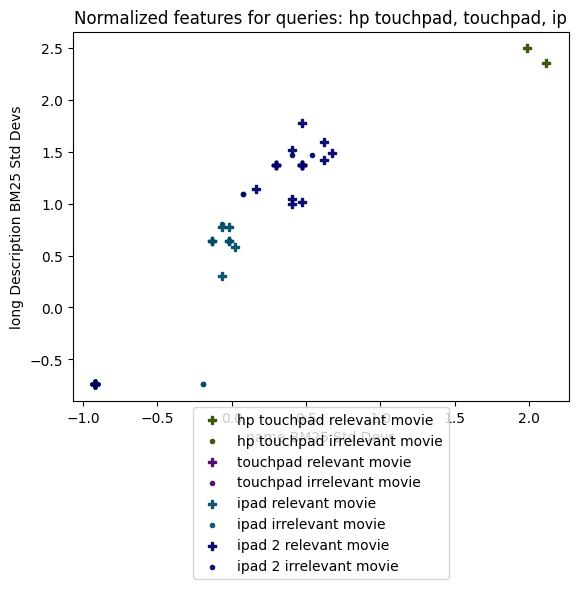

In [24]:
from plot import plot_judgments

plot_judgments(qids=[0,2,1,9], 
               xlabel="name BM25 Std Devs",
               ylabel="long Description BM25 Std Devs",
               title_prepend="Normalized features for queries:",
               judg_list=normed_judgments)

# Pairwise Transform

In [25]:
import numpy as np
from judgements import *

def pairwise_transform(normed_judgments, weigh_difference = True):
        
    from itertools import groupby
    predictor_deltas = []
    feature_deltas = []
    
    # For each query's judgments
    for qid, query_judgments in groupby(normed_judgments, key=lambda j: j.qid):

        # Annoying issue consuming python iterators, we ensure we have two
        # full copies of each query's judgments
        query_judgments_copy_1 = list(query_judgments) 
        query_judgments_copy_2 = list(query_judgments_copy_1)

        # Examine every judgment combo for this query, 
        # if they're different, store the pairwise difference:
        # +1 if judgment1 more relevant
        # -1 if judgment2 more relevant
        for judgment1 in query_judgments_copy_1:
            for judgment2 in query_judgments_copy_2:
                
                j1_features=np.array(judgment1.features)
                j2_features=np.array(judgment2.features)
                
                if judgment1.grade > judgment2.grade:
                    diff = judgment1.grade - judgment2.grade if weigh_difference else 1.0
                    predictor_deltas.append(+1)
                    feature_deltas.append(diff * (j1_features-j2_features))
                elif judgment1.grade < judgment2.grade:
                    diff = judgment2.grade - judgment1.grade if weigh_difference else 1.0
                    predictor_deltas.append(-1)
                    feature_deltas.append(diff * (j1_features-j2_features))

    # For training purposes, we return these as numpy arrays
    return np.array(feature_deltas), np.array(predictor_deltas)

feature_deltas, predictor_deltas = pairwise_transform(normed_judgments)

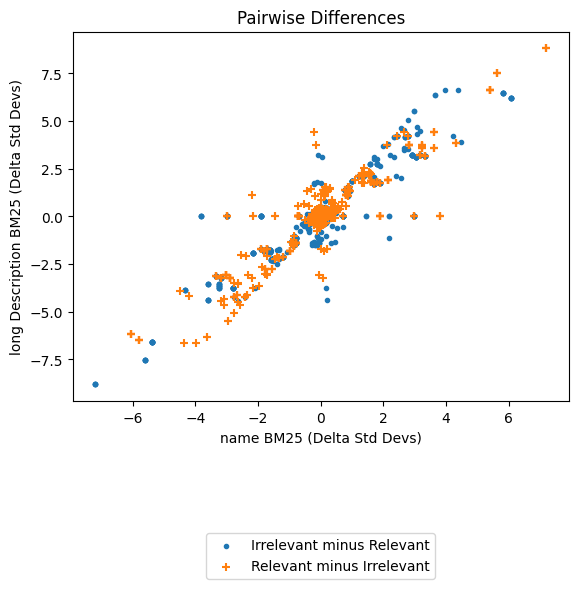

In [26]:
from plot import plot_pairwise_data

# Filter down to a judgment list of our two fav queries 
# out of the normalized data
just_these_queries = []
for j in normed_judgments:
    if j.qid == 0 or j.qid == 2 or j.qid == 1 or j.qid == 9:
        just_these_queries.append(j)

# Pairwise transform just these two, and plot
features, predictors = pairwise_transform(just_these_queries)
plot_pairwise_data(features, predictors,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="long Description BM25 (Delta Std Devs)",
                   title="Pairwise Differences")

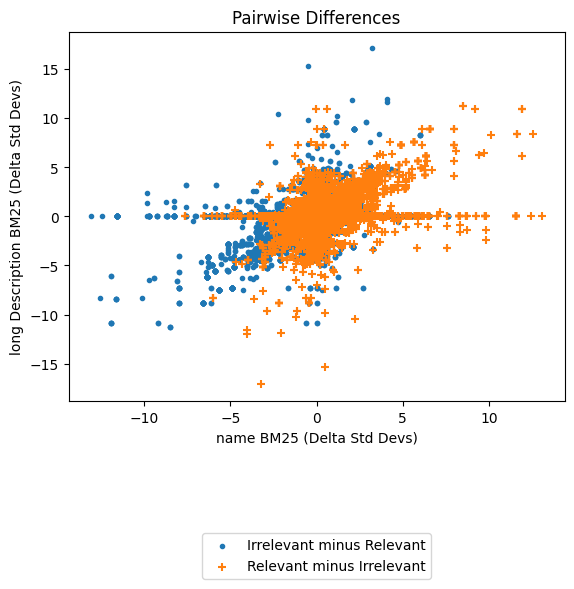

In [63]:
plot_pairwise_data(feature_deltas, predictor_deltas,
                   xlabel="name BM25 (Delta Std Devs)",
                   ylabel="long Description BM25 (Delta Std Devs)",
                   title="Pairwise Differences")

# Training the model

In [27]:
print(feature_deltas)

[[ 0.          0.        ]
 [-2.9785747   0.        ]
 [ 0.          0.        ]
 ...
 [ 0.15661024  0.09438487]
 [ 0.15661024  0.10867467]
 [ 0.15661024  0.13616072]]


In [28]:
print(predictor_deltas)

[ 1  1  1 ... -1 -1 -1]


In [29]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(feature_deltas, predictor_deltas, test_size=0.2, random_state=42)

# Initialize the model
model = svm.LinearSVC(max_iter=10000, verbose=1)

# Train the model
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model:", accuracy)

# Display model coefficients
print("Model coefficients:", model.coef_)

[LibLinear]Accuracy of the model: 0.5687660668380463
Model coefficients: [[ 0.15143764 -0.04823481]]


Uploading the model to Solr

In [30]:
import json

linear_model = {
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
  ],
  "params": {
      "weights": {
      }
  }
}

import math
ftr_model = {}
ftr_names = [ftr['name'] for ftr in feature_set]
for idx, ftr_name in enumerate(ftr_names):
    config = {
        "name": ftr_name,
        "norm": {
            "class": "org.apache.solr.ltr.norm.StandardNormalizer",
            "params": {
                "avg": str(means[idx]),
                "std": str(std_devs[idx])
            }
        }
    }
    linear_model['features'].append(config)
    linear_model['params']['weights'][ftr_name] =  model.coef_[0][idx] 

print(f"PUT {SOLR_URL}/solr/{products_collection}/schema/model-store")
print(json.dumps(linear_model, indent=2))

# Delete old model
resp = requests.delete(f"{SOLR_URL}/solr/{products_collection}/schema/model-store/test_model")


# Upload the model
resp = requests.put(f"{SOLR_URL}/solr/{products_collection}/schema/model-store", json=linear_model)
resp.text

PUT http://search-solr:8983/solr/solr/products/schema/model-store
{
  "store": "test",
  "class": "org.apache.solr.ltr.model.LinearModel",
  "name": "test_model",
  "features": [
    {
      "name": "name_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "1.995231150931371",
          "std": "2.1729671568496927"
        }
      }
    },
    {
      "name": "longDesciption_bm25",
      "norm": {
        "class": "org.apache.solr.ltr.norm.StandardNormalizer",
        "params": {
          "avg": "1.2650490089986017",
          "std": "1.7062946011827902"
        }
      }
    }
  ],
  "params": {
    "weights": {
      "name_bm25": 0.15143763689229306,
      "longDesciption_bm25": -0.048234813222846444
    }
  }
}


''

# Combining all the sections for a sample query 'hp laptop'

In [34]:
query = "hp laptop"

signals_boosts_query = {
    "query": query,
    "fields": ["doc", "boost"],
    "limit": 10,
    "params": {
      "defType": "edismax",
      "qf": "query",
      "sort": "boost desc"
    }
}

signals_boosts = requests.post(f"{SOLR_URL}/{signals_boosting_collection}/select", 
                               json=signals_boosts_query).json()["response"]["docs"]
print(f"Boost Documents for the query hp laptop: \n{signals_boosts}")

Boost Documents for the query hp laptop: 
[{'doc': '883974850921', 'boost': 101}, {'doc': '886111287055', 'boost': 98}, {'doc': '885909436705', 'boost': 96}, {'doc': '886111962129', 'boost': 73}, {'doc': '099802970796', 'boost': 71}, {'doc': '886541012470', 'boost': 66}, {'doc': '883974845064', 'boost': 58}, {'doc': '886541253385', 'boost': 48}, {'doc': '027242827509', 'boost': 47}, {'doc': '886605550375', 'boost': 40}]


## Basic keyword search

Here, if we observe the records carefully. 

For the query "hp laptop", the results it has returned are 

* Lenmar - Lithium-Ion Battery for Select HP Laptops
* HP - Mini Laptop Sleeve
* Lenmar - Battery for HP Pavilion DV6000/2000 Series Laptops
* HP - Lithium-Ion Battery for Select HP Laptops
* HP - Laptop Sleeve - Onyx

None of the records are related to what user wants which is the information about laptop in general. 

In [36]:
collection = "products"
request = {
    "query": query,
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "qf": "name manufacturer longDescription",
      "defType": "edismax",
      "sort": "score desc, upc asc"
    }
}

search_results = requests.post(f"{SOLR_URL}/{collection}/select", json=request).json()["response"]["docs"]
display(HTML(render_search_results(query, search_results)))

## Encriched search

I have used the techniques above by sending signal_boosting information and attribute weights to the Apache Solr and ran the query.

Here we can observe that the results are more favourable to user as it is regarding to laptops in general.


In [37]:
from IPython.display import display,HTML
from searchutil import render_search_results

product_boosts = " ".join(
    [f'"{entry["doc"]}"^{str(entry["boost"])}' 
     for entry in signals_boosts])

collection = "products"
request = {
    "fields": ["upc", "name", "manufacturer", "score"],
    "limit": 5,
    "params": {
      "q": "{!ltr reRankDocs=60000 reRankWeight=2.0 model=test_model efi.keywords=\"" + query + "\"}", # attribute weights are provided in this
      "qf": "name upc manufacturer shortDescription longDescription",
      "defType": "edismax",
      "q": query,
      "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
      "signals_boosting": product_boosts  # Document boosts are provided here
    }
}

search_results = requests.post(f"{SOLR_URL}/{products_collection}/select", json=request).json()
display(HTML(render_search_results(query, search_results['response']['docs'])))